In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


Import the data, convert data types, rename, and include records through 2019.

In [2]:
payrolls <- read.csv('data/PAYNSA.csv')
claims <- read.csv('data/ICNSA.csv')

payrolls <- payrolls |>
mutate(DATE = yearmonth(as.Date(DATE))) |>
rename(Employment = PAYNSA) |>
as_tsibble(index = DATE) |>
filter_index(. ~ 'Dec 2019')

claims <- claims |>
mutate(DATE = as.Date(DATE)) |>
rename(Claims = ICNSA) |>
filter(DATE <= as.Date('2019-12-31'))

Note `payrolls` is a tsibble and `claims` is a data.frame

In [3]:
payrolls |> head()

DATE,Employment
<mth>,<int>
1939 Jan,29296
1939 Feb,29394
1939 Mar,29804
1939 Apr,29786
1939 May,30145
1939 Jun,30520


In [4]:
claims |> head()

,DATE,Claims
,<date>,<int>
1,1967-01-07,346000
2,1967-01-14,334000
3,1967-01-21,277000
4,1967-01-28,252000
5,1967-02-04,274000
6,1967-02-11,276000


## Payrolls

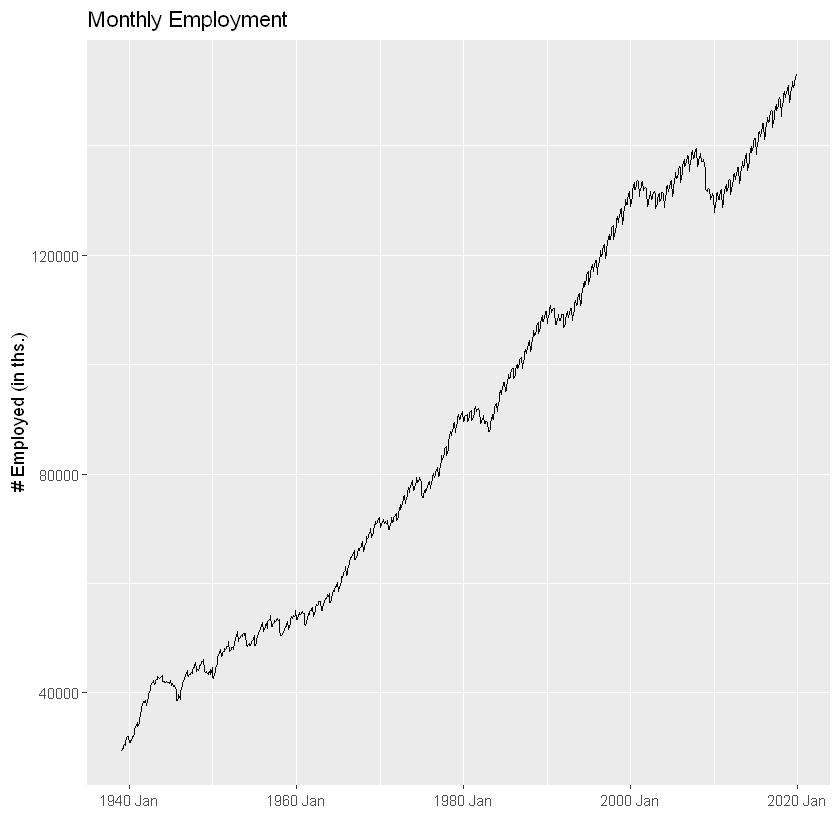

In [5]:
payrolls |> autoplot(Employment) + labs(title='Monthly Employment', x='', y='# Employed (in ths.)')

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


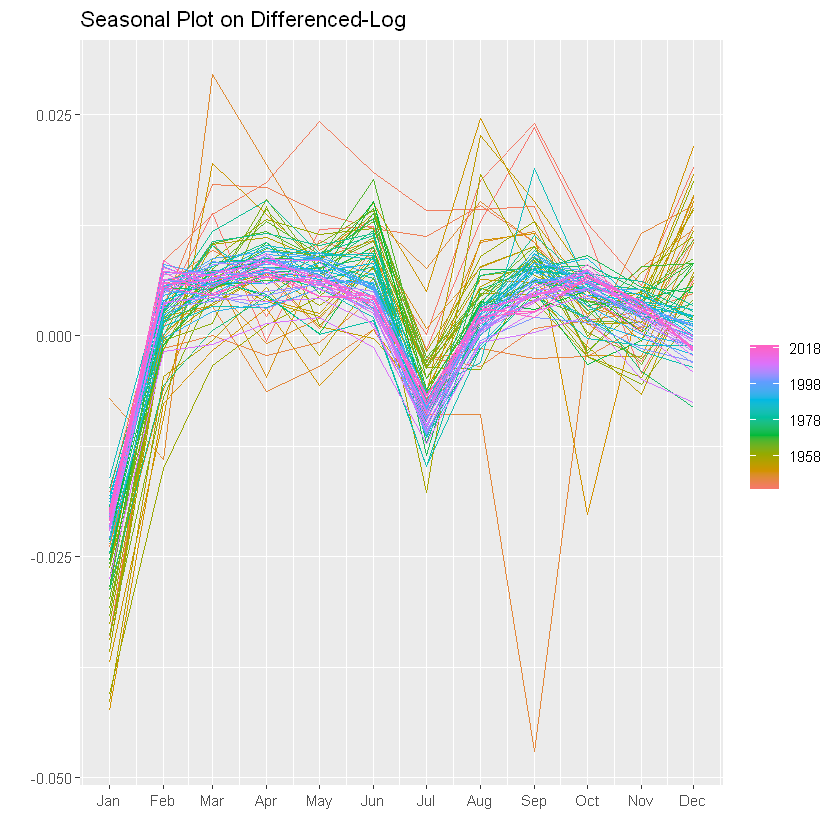

In [6]:
payrolls |> gg_season(difference(log(Employment))) + labs(title='Seasonal Plot on Differenced-Log', x='', y='')

`payrolls` - Strong trend over time. Seasonality most visible in differenced-log data due to relatively small percentage changes period/period in the data. January has large employment declines due to cessation of holiday shopping. Other months have tendencies, however, January is the strongest seasonal period.

## Claims

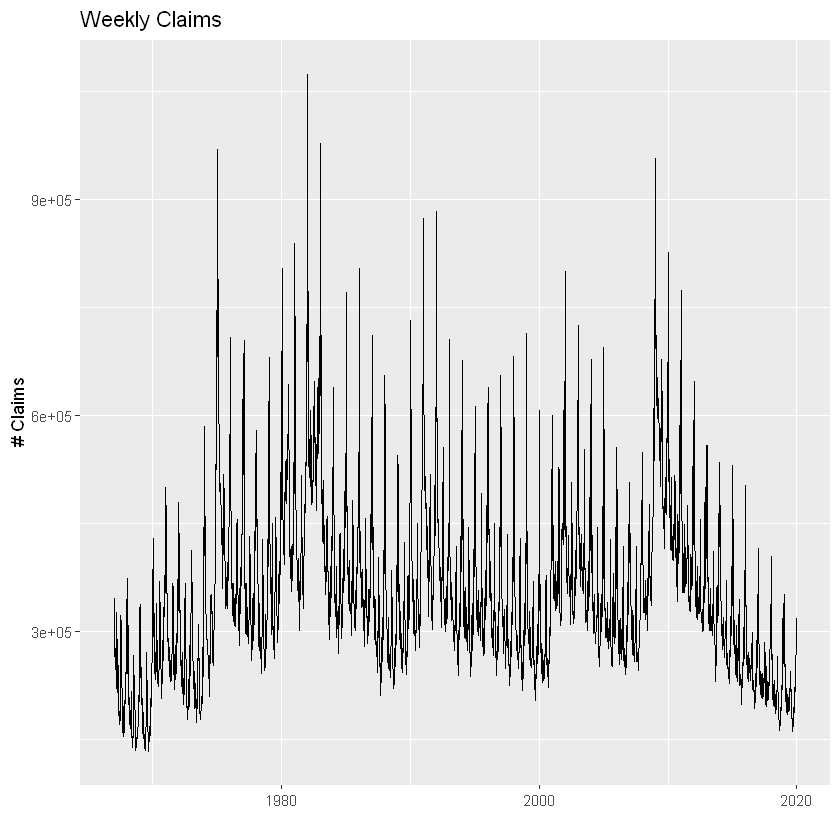

In [7]:
claims |> ggplot(aes(x=DATE, y=Claims)) + geom_line() + labs(title='Weekly Claims', x='', y='# Claims')

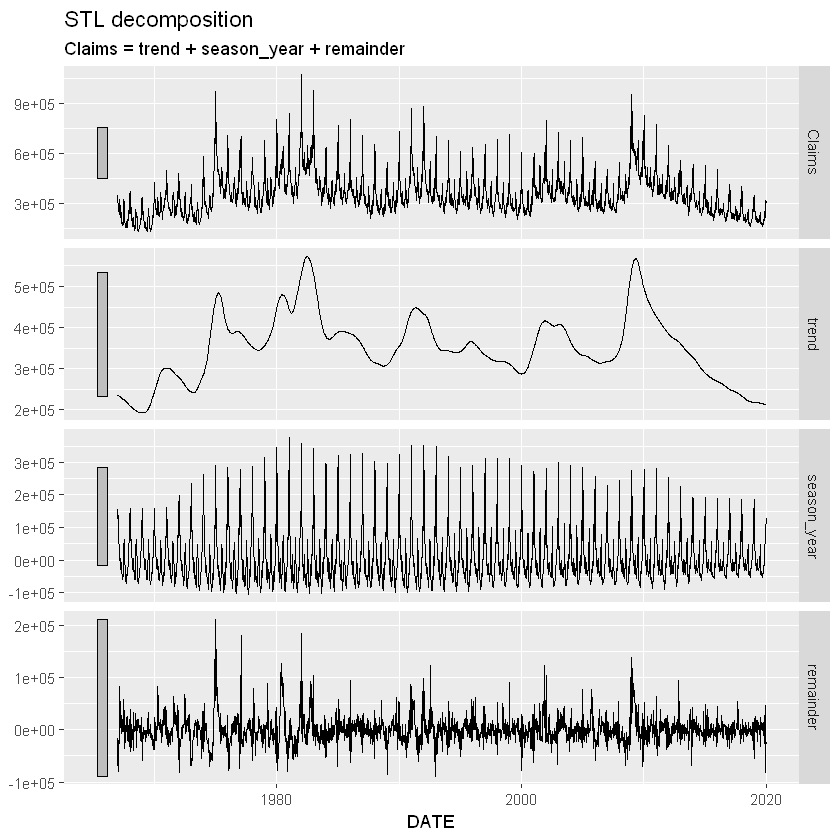

In [8]:
claims_sa <- claims |>
as_tsibble(index=DATE) |>
model(STL(Claims))

claims_sa |> components() |> autoplot()

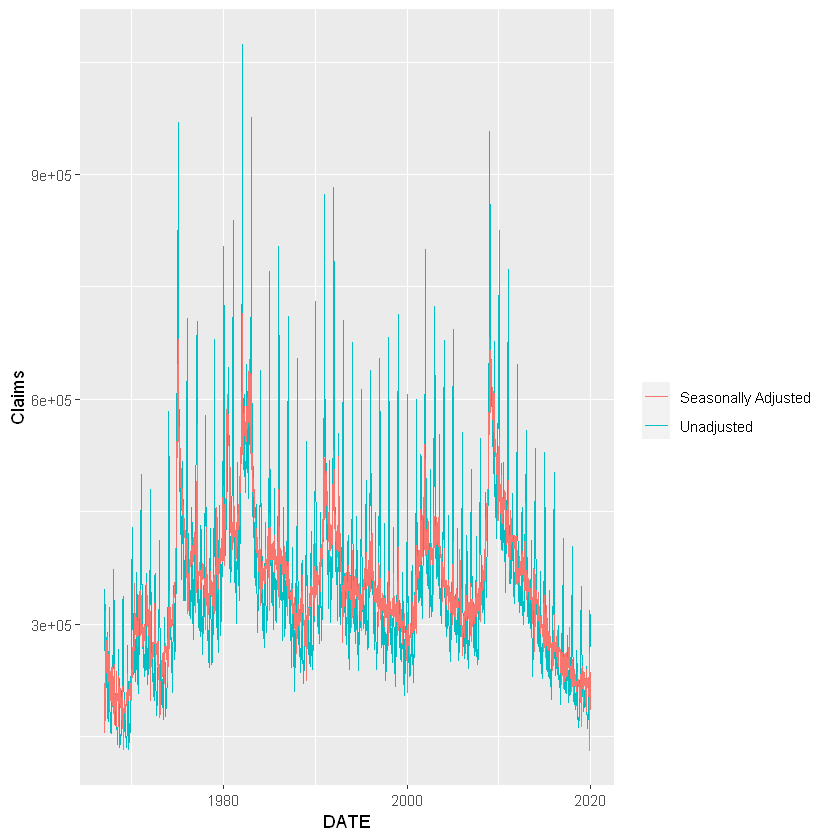

In [9]:
claims_sadj <- claims_sa |> components() %>% select(DATE, season_adjust)

ggplot() + 
geom_line(data=claims, aes(x=DATE, y=Claims, colour='Unadjusted')) +
geom_line(data=claims_sadj, aes(x=DATE, y=season_adjust, colour='Seasonally Adjusted')) +
guides(colour=guide_legend(title=""))

`claims` - No noticable trend over time. Weekly data is volatile, however seasonal decomposition shows persistant seasonal activity. Plotting the seasonally adjusted series against the original significantly smooths the data and appears to remove the seasonality.

## Claims Aggregation
Since `claims` is weekly and `payrolls` is monthly, we need to aggregate to the lower frequency. Since there are a varying number of weeks per month, using a mean summarization will be less distortive than a sum.

In [10]:
monthly_claims <- claims |>
mutate(DATE = yearmonth(floor_date(DATE, 'month'))) |>
group_by(DATE) |>
summarize(avg_Claims = mean(Claims, na.rm=TRUE), sum_Claims = sum(Claims, na.rm=TRUE), .groups = 'drop') |>
as_tsibble(index=DATE)

monthly_claims |> head()

DATE,avg_Claims,sum_Claims
<mth>,<dbl>,<int>
1967 Jan,302250,1209000
1967 Feb,261250,1045000
1967 Mar,251500,1006000
1967 Apr,239400,1197000
1967 May,189000,756000
1967 Jun,179250,717000


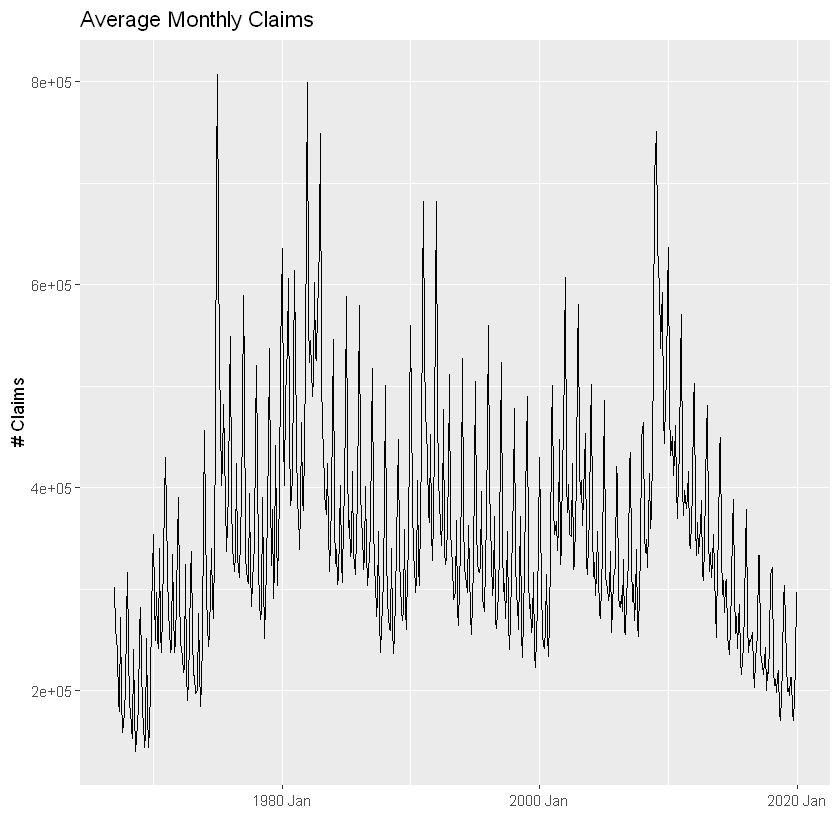

In [11]:
monthly_claims |> autoplot(avg_Claims) + labs(title='Average Monthly Claims', x='', y='# Claims')

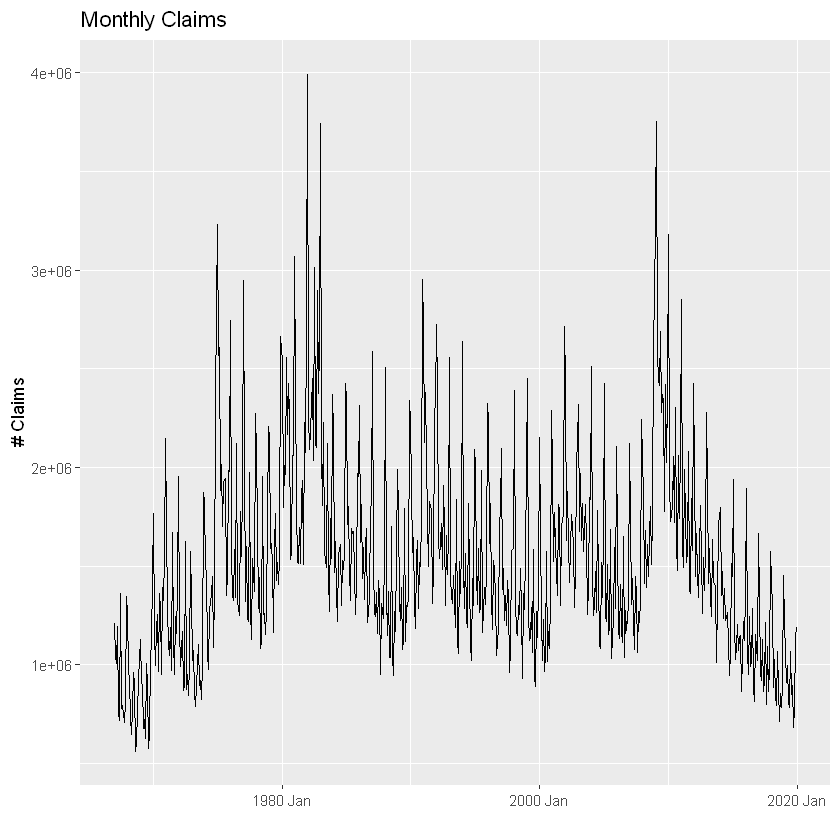

In [12]:
monthly_claims |> autoplot(sum_Claims) + labs(title='Monthly Claims', x='', y='# Claims')

## Forecasting Claims
This will be from the monthly series because that is what we would need for forecasting `payrolls`.

In [13]:
monthly_claims_tr <- monthly_claims |> filter_index(. ~ 'Dec 2018')
monthly_claims_ts <- monthly_claims |> filter_index('Jan 2019' ~ .)

In [14]:
monthly_claims_mdl <- monthly_claims_tr |>
model(
    'Mean Model' = MEAN(avg_Claims),
    'NAIVE Model' = NAIVE(avg_Claims),
    'SNAIVE Model' = SNAIVE(avg_Claims ~ lag('1 year')),
    'Random Walk' = RW(avg_Claims ~ drift())
)

monthly_claims_mdl |> accuracy() |> select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mean Model,1.555444e-11,109522.85,25.79334,0.7989605
NAIVE Model,-1.849920e+01,69430.09,15.19851,0.0844860
SNAIVE Model,-7.646275e+01,76522.84,13.73381,0.9266375
Random Walk,4.764822e-12,69430.08,15.19828,0.0844860


Lowest MAPE (mean absolute percent error) is on the seasonal naive model.

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


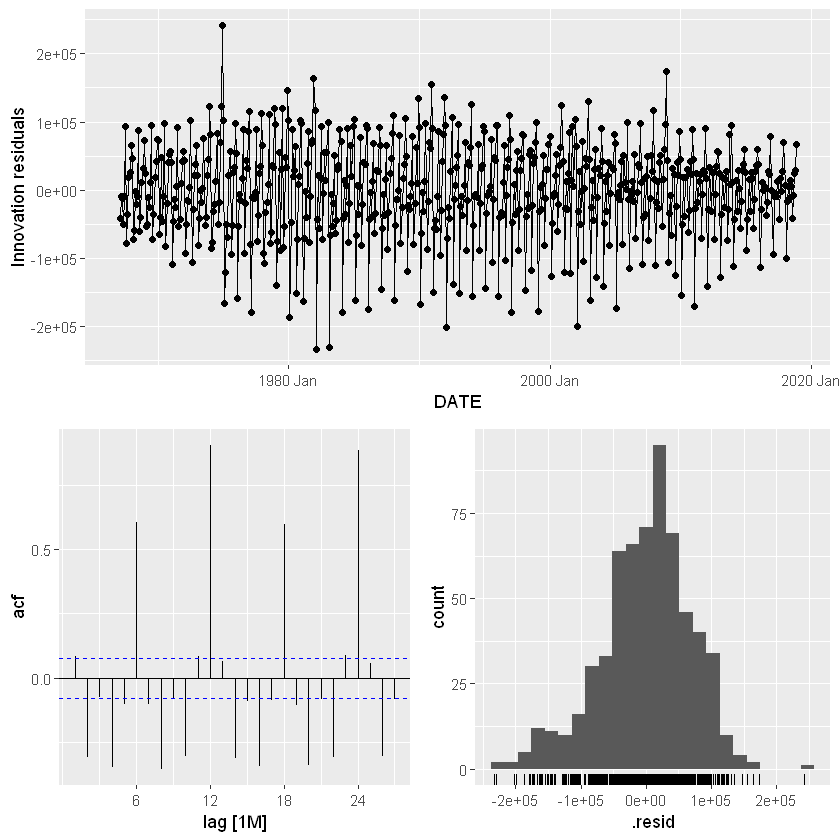

In [15]:
monthly_claims_mdl |> select(`Random Walk`) |> gg_tsresiduals()

Residuals for the random walk do not capture the seasonality.

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_bin()`)."


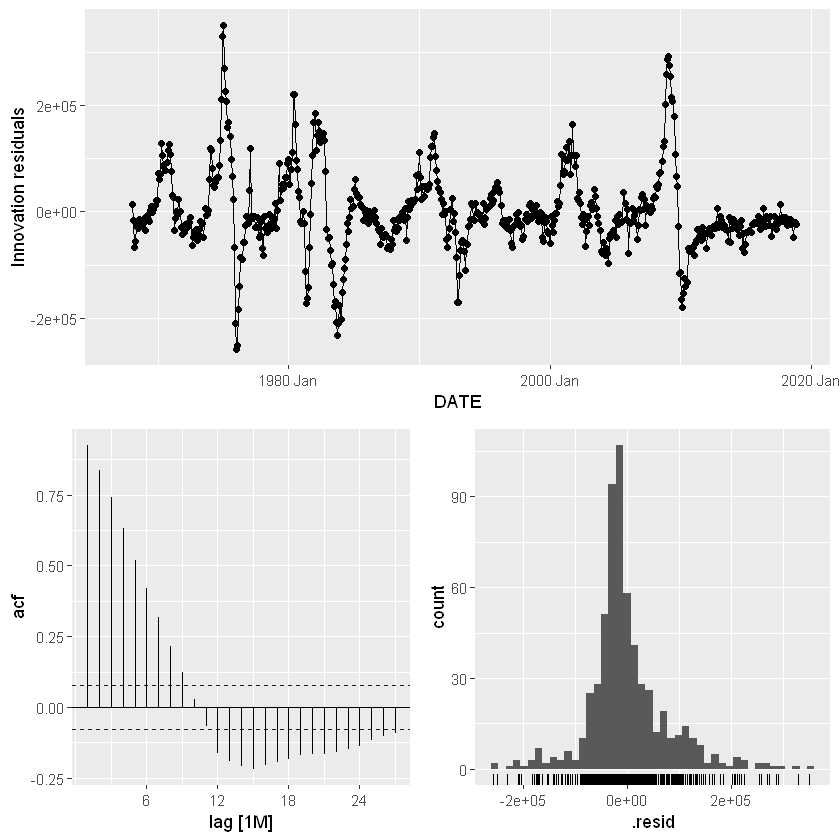

In [16]:
monthly_claims_mdl |> select(`SNAIVE Model`) |> gg_tsresiduals()

Seasonal naive captures the residuals, however signficant serial correlation.

In [17]:
monthly_claims_mdl_forecasts <- monthly_claims_mdl |>
forecast(monthly_claims_ts)

monthly_claims_mdl_forecasts |>
accuracy(monthly_claims_ts) |>
select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mean Model,-134084.282,139947.499,66.072061,0.2750422
NAIVE Model,-72122.700,82512.979,37.955957,0.2750422
Random Walk,-72002.455,82404.967,37.912208,0.2748644
SNAIVE Model,-2352.267,7085.019,2.206085,-0.1688501


Seasonal naive has the lowest error by far compared to the other models. Based on seasonal naive with the smallest error in training, test we will proceed with it. Note the forecasts will likely contain bias due to serial correlation.

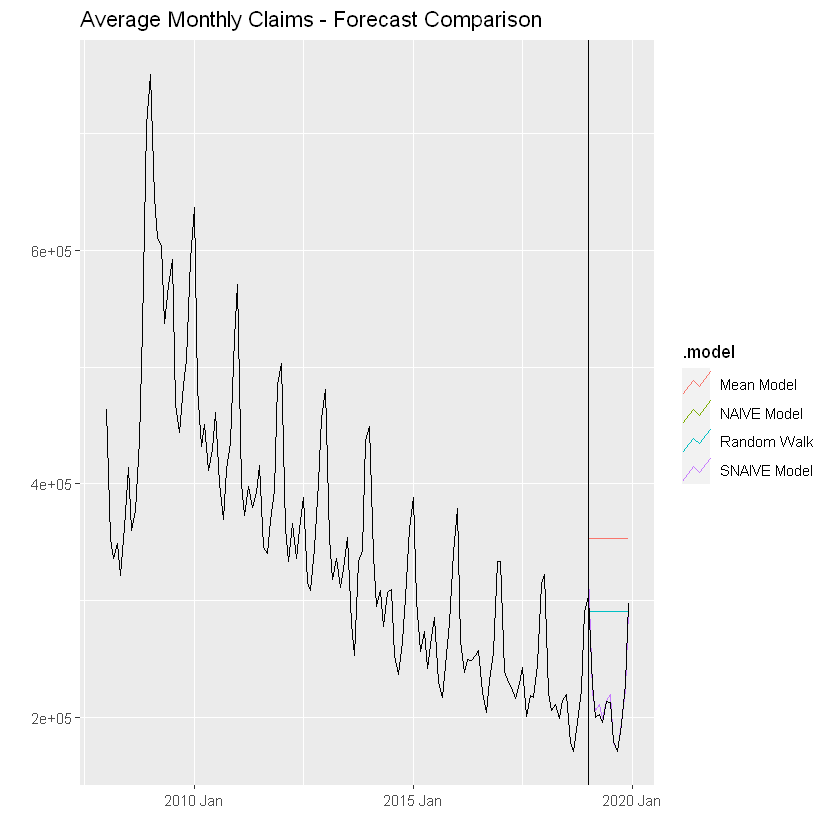

In [18]:
monthly_claims_mdl_forecasts |>
autoplot(level=NULL) +
autolayer(monthly_claims |> filter_index('2008 Jan' ~ .), avg_Claims) +
geom_vline(xintercept = as.Date('2019-01-01')) +
labs(title='Average Monthly Claims - Forecast Comparison', x='', y='')

## Combine Training and Forecast Claims
This will be for the evalation in the `payrolls` model. We will use the best forecast model (`seasonal NAIVE`).

In [19]:
claims_forecasts <- monthly_claims_mdl_forecasts |>
filter(.model == 'SNAIVE Model') |>
as.data.frame() |>
select(DATE, .mean) |>
rename(avg_Claims = .mean) |>
as_tsibble(index=DATE)

claims_forecasts

DATE,avg_Claims
<mth>,<dbl>
2019 Jan,321816.8
2019 Feb,221394.2
2019 Mar,205243.4
2019 Apr,211109.8
2019 May,198841.2
2019 Jun,213828.0
2019 Jul,219568.8
2019 Aug,178572.0
2019 Sep,170923.4


In [20]:
corrected_claims <- monthly_claims_tr |>
select(DATE, avg_Claims) |>
bind_rows(claims_forecasts)

## Prep Payrolls Data

In [21]:
mdl_data <- payrolls |>
inner_join(corrected_claims, by='DATE')

mdl_data |> head()

DATE,Employment,avg_Claims
<mth>,<int>,<dbl>
1967 Jan,64439,302250
1967 Feb,64377,261250
1967 Mar,64741,251500
1967 Apr,65144,239400
1967 May,65540,189000
1967 Jun,66451,179250


In [22]:
mdl_data |> tail()

DATE,Employment,avg_Claims
<mth>,<int>,<dbl>
2019 Jul,150658,219568.8
2019 Aug,151094,178572.0
2019 Sep,151510,170923.4
2019 Oct,152500,195425.0
2019 Nov,153095,224007.2
2019 Dec,152845,290725.0


In [23]:
mdl_tr <- mdl_data |>
filter_index(. ~ '2018 Dec')

mdl_ts <- mdl_data |>
filter_index('2019 Jan' ~ .)

## Employment Models

In [24]:
employment_mdl <- mdl_tr |>
model(
    'Trend' = TSLM(Employment ~ trend()),
    'Seasonal Trend' = TSLM(Employment ~ trend() + season()),
    'Seasonal Trend Claims' = TSLM(Employment ~ trend() + season() + avg_Claims),
    'SNAIVE' = SNAIVE(Employment),
    'Mean' = MEAN(Employment),
)

employment_mdl |> report() |>
select(.model, r_squared, AICc)

Warning message in report.mdl_df(employment_mdl):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,r_squared,AICc
<chr>,<dbl>,<dbl>
Trend,0.9680623,10488.81
Seasonal Trend,0.9692001,10488.83
Seasonal Trend Claims,0.9695267,10484.27
SNAIVE,NA,NA
Mean,NA,NA


AICc is slightly lower for the seasonal trend model including claims. However, it is marginal.

In [25]:
employment_mdl |> accuracy() |>
select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Trend,-6.719792e-13,4445.548,3.200480,0.9780283
Seasonal Trend,4.715512e-13,4365.638,3.143578,0.9973188
Seasonal Trend Claims,-3.532936e-13,4342.429,3.201656,0.9964744
SNAIVE,1.627010e+03,2511.694,2.097604,0.9904314
Mean,-6.632051e-12,24875.582,22.173273,0.9944524


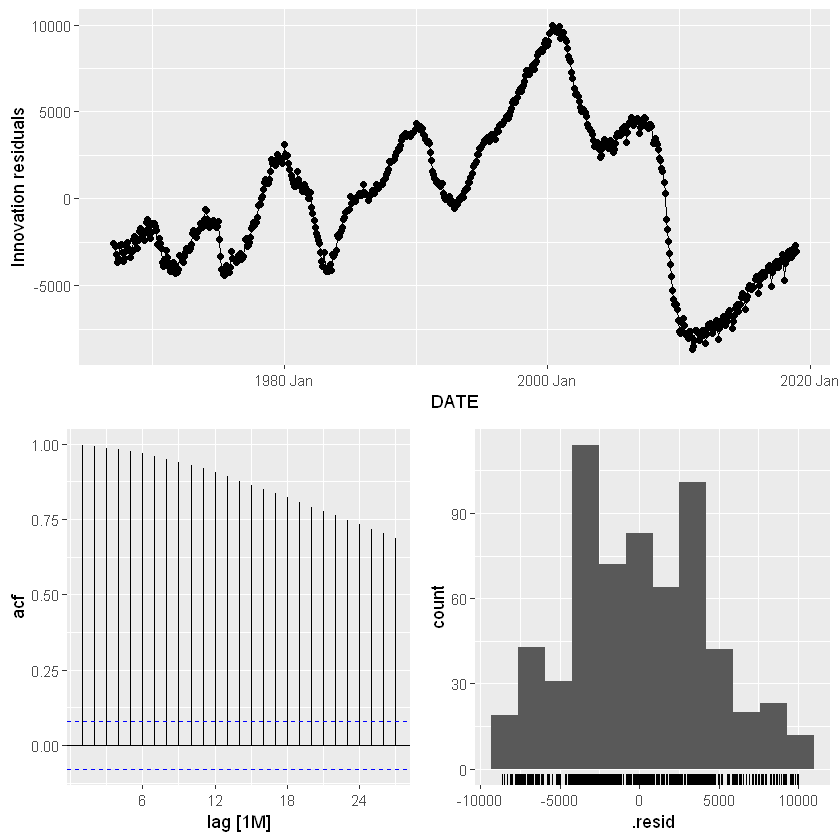

In [26]:
employment_mdl |> select(`Seasonal Trend Claims`) |> gg_tsresiduals()

`Seasonal Trend Claims` - clear serial correlation, patterns in the residuals.

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_bin()`)."


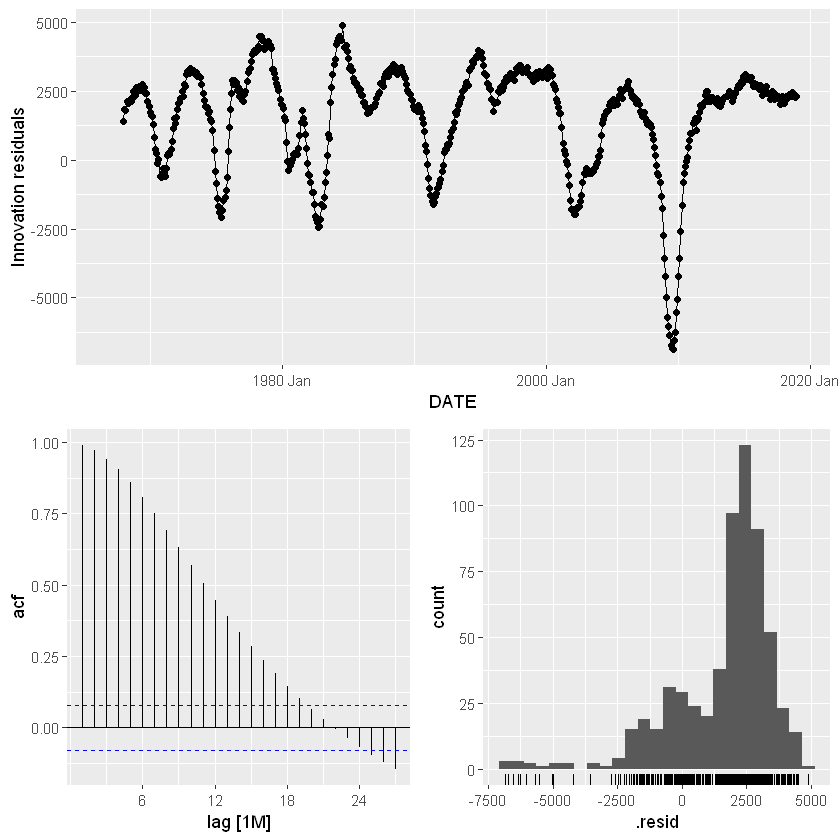

In [27]:
employment_mdl |> select(`SNAIVE`) |> gg_tsresiduals()

`seasonal naive` - Residuals have signficant serial correlation, clear patterns in the residuals, distribution not normal.

`seasonal naive` seems to have the lowest RMSE on the training data.

In [28]:
employment_mdl_forecasts <- employment_mdl |>
forecast(mdl_ts)

employment_mdl_forecasts |> accuracy(mdl_ts) |>
select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mean,40989.670,41019.115,27.154925,0.6743949
SNAIVE,1996.000,2003.147,1.323463,0.2307901
Seasonal Trend,-2194.458,2219.365,1.456462,0.5431251
Seasonal Trend Claims,-2903.560,2930.693,1.926861,0.4627107
Trend,-2217.778,2487.261,1.477458,0.6248335


`seasonal naive` seems to have the lowest RSME on the test data.

`Conclusion` - Seems the `seasonal naive` is the best weighing the training, test, and residuals. Residuals are an issue for each model.

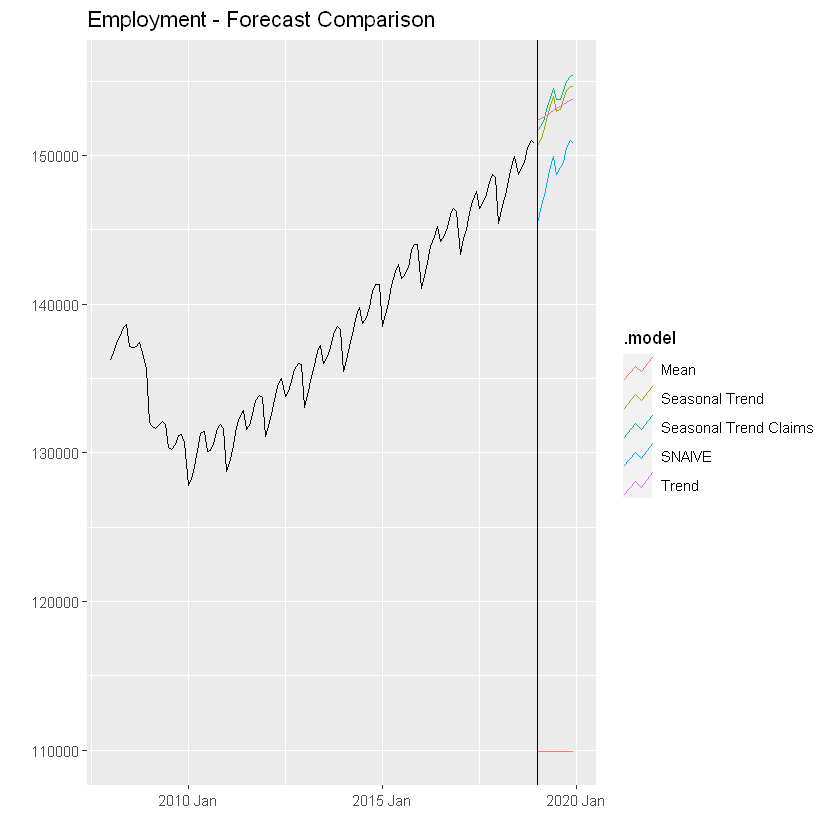

In [29]:
employment_mdl_forecasts |>
autoplot(level=NULL) +
autolayer(mdl_tr |> filter_index('2008 Jan' ~ .), Employment) +
geom_vline(xintercept = as.Date('2019-01-01')) +
labs(title='Employment - Forecast Comparison', x='', y='')

## Out of Sample Forecasts
Will need to rerun on the full data to forecast. Forecast `claims` using `seasonal naive`.

In [30]:
monthly_claims_mdl_fnl <- monthly_claims |>
model(
    'SNAIVE Model' = SNAIVE(avg_Claims ~ lag('1 year')),
) |>
forecast(h = 4) |>
as.data.frame() |>
select(DATE, .mean) |>
rename(avg_Claims = .mean) |>
as_tsibble(index=DATE)

monthly_claims_mdl_fnl 

DATE,avg_Claims
<mth>,<dbl>
2020 Jan,303577.0
2020 Feb,227688.2
2020 Mar,199595.0
2020 Apr,202238.0


Use `claim` forecasts to include within forecasts of `employment`.

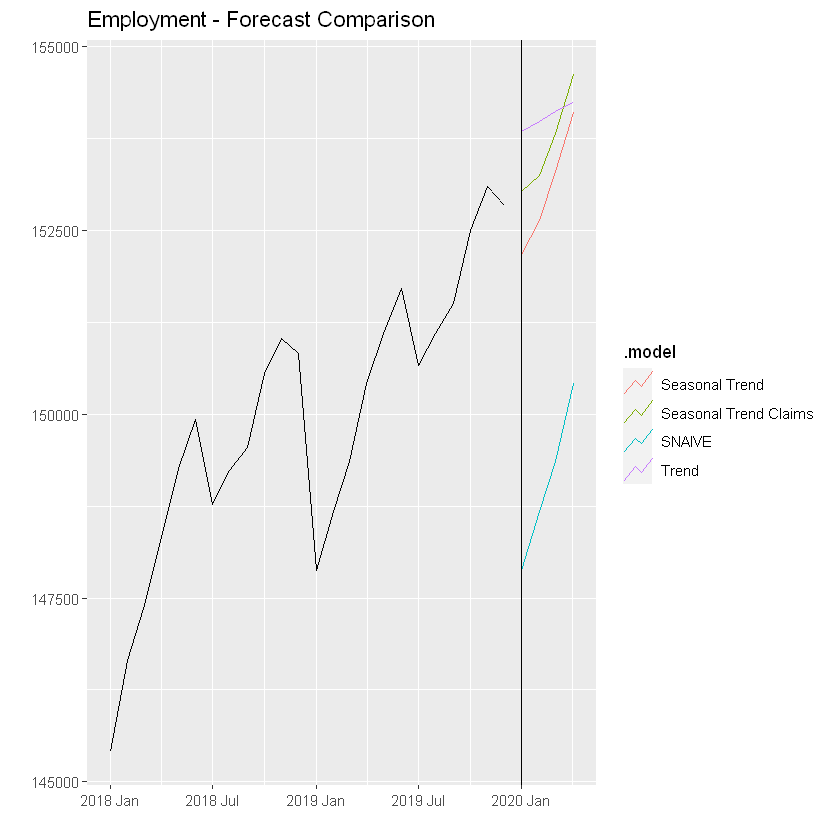

In [31]:
employment_mdl_full <- mdl_data |>
model(
    'Trend' = TSLM(Employment ~ trend()),
    'Seasonal Trend' = TSLM(Employment ~ trend() + season()),
    'Seasonal Trend Claims' = TSLM(Employment ~ trend() + season() + avg_Claims),
    'SNAIVE' = SNAIVE(Employment),
) |>
forecast(monthly_claims_mdl_fnl)

employment_mdl_full |>
autoplot(level=NULL) +
autolayer(mdl_data |> filter_index('2018 Jan' ~ .), Employment) +
geom_vline(xintercept = as.Date('2020-01-01')) +
labs(title='Employment - Forecast Comparison', x='', y='')
